# ノック61 - 輸送最適化問題を解く

前章の輸送最適化問題を、最適化計算ライブラリによって解いていく。  
ここではpulpとortoolpyを用いる。

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars,addvals

まずは各種ファイルを読み込む

In [2]:
demand = pd.read_csv("demand.csv")
demand

# 各工場が最低限受け入れなくてはならない最低限の数

,F1,F2,F3,F4
0,28,29,31,25


In [3]:
supply = pd.read_csv("supply.csv")
supply

#各倉庫が供給できる最大の数

,W1,W2,W3
0,35,41,42


In [4]:
cost = pd.read_csv("trans_cost.csv")
cost = cost.pivot_table(index = "工場")
cost

# 各倉庫から各工場への輸送費

,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


上記のdemand, costの制約条件を満たしつつ、各倉庫から各工場にそれぞれどの程度輸送すればコストが最も抑えられるのかを計算する。

In [5]:
# データフレームから要素を抜き出すための組み合わせを作成

nw = len(cost.index)
nf = len(cost.columns)
pr = list(product(range(nw),range(nf)))
pr

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3)]

In [6]:
# 最適化モデルを作成

m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

m1 += lpSum(cost.iloc[(i,j)] * v1[(i,j)] for i,j in pr)
for i in range(nf):
    m1 += lpSum(v1[j,i] for j in range(nw)) >= demand.iloc[0,i]
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= supply.iloc[0,i]
    
m1.solve()

1

In [7]:
# 最適化された輸送量をデータフレーム化

df_tr_cost = cost.copy()

for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_cost.iloc[i,j] = value(v1[i,j])
df_tr_cost

,F1,F2,F3,F4
工場,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


In [9]:
# 結果

print("総輸送コスト : " + str(value(m1.objective)))

総輸送コスト : 1296.0


上記のような輸送ルートと輸送量によって、総輸送コストが1296に抑えられる事が分かった。  

# ノック62 - 最適輸送ルートをネットワークで確認

ノック57で用いたネットワークの可視化手法に、ノック61の最適輸送ルートをあてはめる。

In [10]:
import networkx as nx

In [11]:
route_pos = pd.read_csv("trans_route_pos.csv")
route_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


In [12]:
G = nx.Graph()

#点のリストを作成
nodes = []
for i in range(0,3):
    nodes.append(route_pos.columns[i])
for j in range(3,7):
    nodes.append(route_pos.columns[j])
nodes

['W1', 'W2', 'W3', 'F1', 'F2', 'F3', 'F4']

In [13]:
#枝のリストを作成
edges = []
for i in range(0,3):
    for j in range(3,7):
        edges.append((route_pos.columns[i],route_pos.columns[j]))
edges

[('W1', 'F1'),
 ('W1', 'F2'),
 ('W1', 'F3'),
 ('W1', 'F4'),
 ('W2', 'F1'),
 ('W2', 'F2'),
 ('W2', 'F3'),
 ('W2', 'F4'),
 ('W3', 'F1'),
 ('W3', 'F2'),
 ('W3', 'F3'),
 ('W3', 'F4')]

In [14]:
#点と枝を追加        
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [15]:
# route_posのcsvファイルから、各点のポジション情報を抽出

pos = {}    
for i in range(0,7):
    pos[nodes[i]] = route_pos[route_pos.columns[i]]
pos

{'W1': 0    0
 1    1
 Name: W1, dtype: int64,
 'W2': 0    0
 1    2
 Name: W2, dtype: int64,
 'W3': 0    0
 1    3
 Name: W3, dtype: int64,
 'F1': 0    4.0
 1    0.5
 Name: F1, dtype: float64,
 'F2': 0    4.0
 1    1.5
 Name: F2, dtype: float64,
 'F3': 0    4.0
 1    2.5
 Name: F3, dtype: float64,
 'F4': 0    4.0
 1    3.5
 Name: F4, dtype: float64}

In [16]:
# 次に、ノック61で作成したdf_tr_costから重みの情報をリストに代入

weight = []
for i in range(len(df_tr_cost.index)):
    for j in range(len(df_tr_cost.columns)):
        weight.append(df_tr_cost.iloc[i,j]) 

#さらに重みを少しダウンサイズする
        
weight = [i/5  for i in weight]
weight

[5.6, 1.4, 0.0, 0.0, 0.0, 0.0, 6.2, 1.0, 0.0, 4.4, 0.0, 4.0]

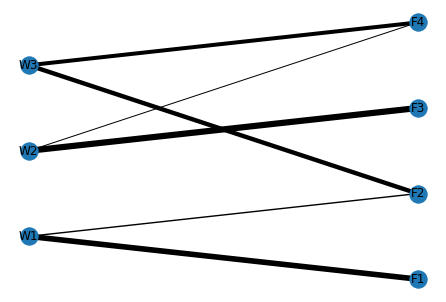

In [17]:
# ネットワークの可視化

nx.draw(G, with_labels = True, pos = pos, width = weight)

# ノック63 - 最適輸送ルートが成約条件ないに収まっているかの確認  (ここから自身の解答)

上記の最適輸送ルートが成約条件にあてはまるかを、ノック60で求めた関数を用いて求める。

In [27]:
# 関数の再定義

def trans_cost_flag(df_tr):
    demand_list = []
    for j in range(len(demand.columns)):
        if df_tr.iloc[:,j].sum() >= demand.iloc[0,j]:
            demand_list.append(1)
        else :
            demand_list.append(0)
    print("需要条件計算結果 : " + str(demand_list))
    
    supply_list = []
    for i in range(len(supply.columns)):
        if df_tr.iloc[i,:].sum() <= supply.iloc[0,i]:
            supply_list.append(1)
        else :
            supply_list.append(0)
    print("供給条件計算結果 : " + str(supply_list))

In [29]:
# 成約条件にあてはまるかどうかを調べる

trans_cost_flag(df_tr_cost)

需要条件計算結果 : [1, 1, 1, 1]
供給条件計算結果 : [1, 1, 1]


条件にはあてはまっている。